In [47]:
# Step 1: Data Preprocessing
import pandas as pd

In [48]:
# Load the dataset
data = pd.read_csv("/MarketPricePrediction.csv")

In [49]:
# Handle missing values
data.dropna(inplace=True)  # Drop rows with missing values

In [50]:
# Encoding categorical variables
data = pd.get_dummies(data, columns=['market', 'state', 'city'])

In [51]:
# Optionally, handle datetime variables
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

<ipython-input-51-eca60921c1ac>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


In [52]:
# Optionally, scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['quantity', 'priceMin', 'priceMax', 'priceMod']] = scaler.fit_transform(data[['quantity', 'priceMin', 'priceMax', 'priceMod']])

In [53]:
# Set the target variable
target_column = "priceMod"

# Optionally, split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(target_column, axis=1), data[target_column], test_size=0.2, random_state=42)

In [54]:
# Step 2: Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt

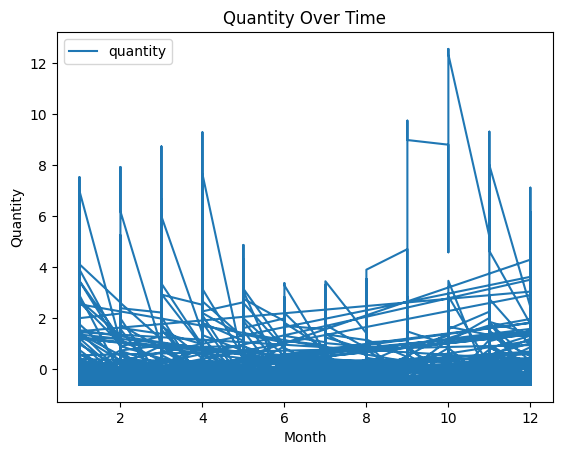

In [55]:
# Plot temporal patterns
data.plot(x='month', y='quantity', kind='line')
plt.title('Quantity Over Time')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.show()

In [56]:
# Identify seasonality, trends, and anomalies
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [57]:
# Perform decomposition
decomposition = seasonal_decompose(data['priceMod'], model='additive', period=12)  # Assuming seasonality period is 12 months

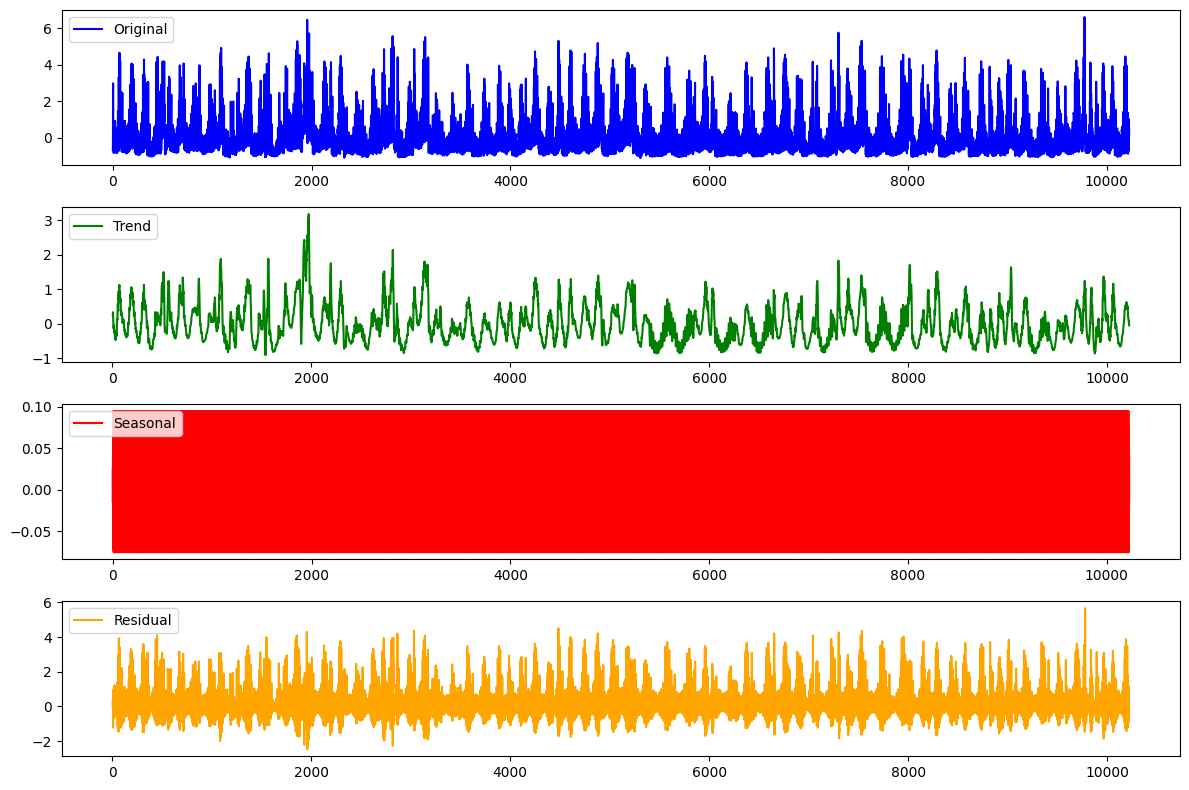

In [58]:
# Plot decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['priceMod'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='orange')
plt.legend(loc='upper left')
plt.tight_layout()

In [59]:
# Plot autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x400 with 0 Axes>

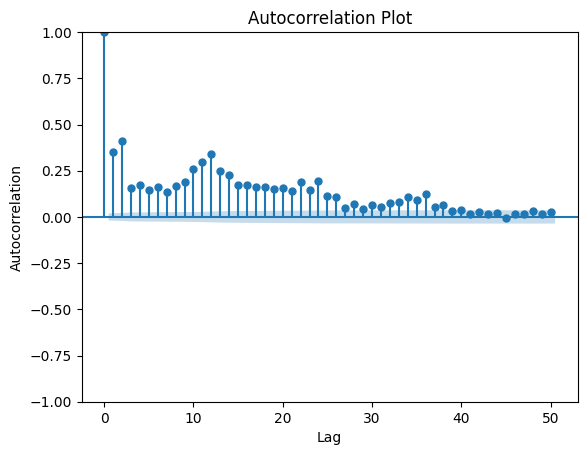

In [60]:
plt.figure(figsize=(12, 4))
plot_acf(data['priceMod'], lags=50, alpha=0.05)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [61]:
# Step 3: Feature Engineering
# Create lagged variables
data['quantity_lag_1'] = data['quantity'].shift(1)
data['quantity_lag_2'] = data['quantity'].shift(2)

In [62]:
# Create rolling statistics
data['quantity_roll_mean'] = data['quantity'].rolling(window=3).mean()
data['quantity_roll_std'] = data['quantity'].rolling(window=3).std()

In [63]:
import numpy as np

# Define Fourier series decomposition function
def fourier_series(t, p, n_harm):
    """Create Fourier series for seasonal indicators."""
    series = np.zeros(len(t))
    for i in range(1, n_harm+1):
        series += np.real(p[i-1]) * np.sin(2 * np.pi * i * t) + np.real(p[n_harm+i-1]) * np.cos(2 * np.pi * i * t)
    return series

In [64]:
# Assuming decomposition.seasonal contains the seasonal component
# Assuming decomposition.seasonal.index is datetime index
t = np.linspace(0, 1, len(decomposition.seasonal))
n_harm = 10  # Number of harmonics to use, adjust as needed

In [65]:
# Fit Fourier series
coefficients = np.fft.fft(decomposition.seasonal)
seasonal_indicators = fourier_series(t, coefficients, n_harm)

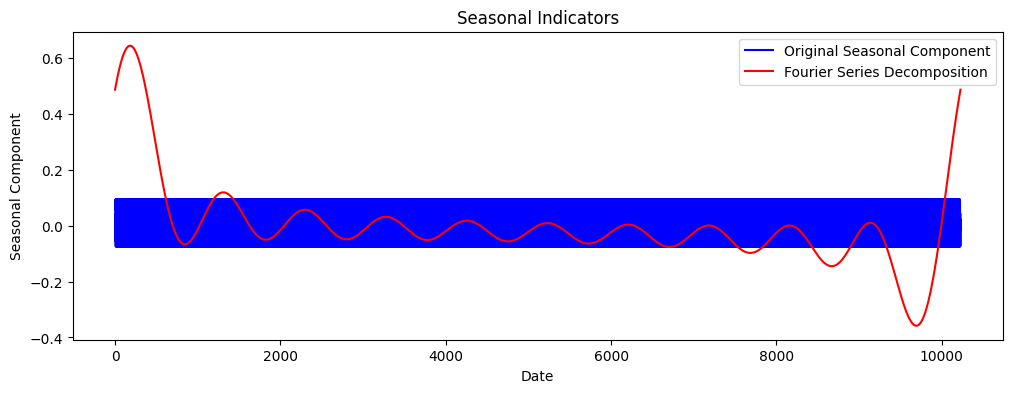

In [66]:
# Plot seasonal indicators
plt.figure(figsize=(12, 4))
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label='Original Seasonal Component', color='blue')
plt.plot(decomposition.seasonal.index, seasonal_indicators, label='Fourier Series Decomposition', color='red')
plt.title('Seasonal Indicators')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.legend()
plt.show()

In [67]:
!python -m pip install prophet

In [68]:
# Step 4: Model Selection and Training
# Import models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [80]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Initialize and train models
arima_model = ARIMA(y_train, order=(5,1,0)).fit()
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
X_train['date'] = pd.to_datetime(X_train['date'], format='%Y-%m-%d')  # Assuming 'date' is the column name
prophet_model = Prophet()
prophet_model.fit(pd.DataFrame({'ds': X_train['date'], 'y': y_train}))



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

In [81]:
# Step 5: Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA evaluation
arima_pred = arima_model.forecast(steps=len(y_test))
arima_mae = mean_absolute_error(y_test, arima_pred)
arima_mse = mean_squared_error(y_test, arima_pred)
arima_rmse = np.sqrt(arima_mse)

# SARIMA evaluation
sarima_pred = sarima_model.forecast(steps=len(y_test))
sarima_mae = mean_absolute_error(y_test, sarima_pred)
sarima_mse = mean_squared_error(y_test, sarima_pred)
sarima_rmse = np.sqrt(sarima_mse)

# Prophet evaluation
future = prophet_model.make_future_dataframe(periods=len(y_test))
prophet_pred = prophet_model.predict(future)[-len(y_test):]
prophet_mae = mean_absolute_error(y_test, prophet_pred['yhat'])
prophet_mse = mean_squared_error(y_test, prophet_pred['yhat'])
prophet_rmse = np.sqrt(prophet_mse)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [82]:
print("ARIMA Model Evaluation:")
print(f"Mean Absolute Error (MAE): {arima_mae}")
print(f"Mean Squared Error (MSE): {arima_mse}")
print(f"Root Mean Squared Error (RMSE): {arima_rmse}")
print("\n")

print("SARIMA Model Evaluation:")
print(f"Mean Absolute Error (MAE): {sarima_mae}")
print(f"Mean Squared Error (MSE): {sarima_mse}")
print(f"Root Mean Squared Error (RMSE): {sarima_rmse}")
print("\n")

print("Prophet Model Evaluation:")
print(f"Mean Absolute Error (MAE): {prophet_mae}")
print(f"Mean Squared Error (MSE): {prophet_mse}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse}")

ARIMA Model Evaluation:
Mean Absolute Error (MAE): 0.7412512252152903
Mean Squared Error (MSE): 1.0908864742259923
Root Mean Squared Error (RMSE): 1.0444551087653275


SARIMA Model Evaluation:
Mean Absolute Error (MAE): 0.7240307303713804
Mean Squared Error (MSE): 1.0864249302362214
Root Mean Squared Error (RMSE): 1.0423170967782411


Prophet Model Evaluation:
Mean Absolute Error (MAE): 2.1830841999434574
Mean Squared Error (MSE): 7.381739442342424
Root Mean Squared Error (RMSE): 2.716935671366259
